# EMAT30008 Scientific Computing

Michael Johnson - fr19042@bristol.ac.uk - 1962648

## Introduction

In this report, we will be show casing the capabilities of code written to solve ODEs, PDEs and performing numerical continuation, As well as this we'll be discussing the design choices and learning process that went along with the development of the code.
## Summary of Software

The software consists of four modules: 
1) integrate: contains solve_to function for integrating ODEs
2) BVP: contains shooting and solve_BVP
3) PDEs : Contains diffusion_solver for solving the diffusion-reaction equation.
4) continuation: contains continuation for solving ODE equilibria/period orbits for varying parameters.

Let's start by importing the necessary libraries for result plotting.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from scipy.optimize import root
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from IPython.display import Image

%matplotlib inline

#### ODE integration methods

The module `integrate.py` consists of three functions, `euler_step`, `RK4_step` and `solve_to`. `euler_step` and `RK4_step` both increment a solution by a single time step according to the forward euler and fourth order runge-kutta methods respectively. The core function is `solve_to` which calls either `euler_step` or `RK4_step` depending on user input to integrate an ODE over some time span. The user can choose a start and end time, the time-stepping method used and the size of time-step for integrating the chosen ODE with initial condition x0.

We can perform a simple demonstration for two ODEs as outlined in the table below. The code is shown handling different solution dimensions, time spans and parameters alongside the analytical solution.

<style>
table {
  border-collapse: collapse;
  width: 100%;
}
th, td {
  border: 1px solid black;
  padding: 8px;
  text-align: left;
  vertical-align: top;
}
th {
  background-color: #f2f2f2;
}
.math {
  display: block;
  text-align: left;
  margin-bottom: 1em;
}
</style>

<table>
    <tr>
        <th style="width: 15%;"> </th>
        <th style="width: 45%;">ODE Equation</th>
        <th style="width: 40%;">Analytical Solution</th>
    </tr>
    <tr>
        <td></td>
        <td><div class="math">$\dot{x}(t) = x(t)$</div></td>
        <td><div class="math">$ x(t) = x_{0}e^{t} $</div></td>
    </tr>
    <tr>
        <td>Hopf Normal Form:</td>
        <td>
            <div class="math">$\dot{u_1} = \beta u_1 - u_2 + \sigma u_1(u_1^2 + u_2^2)$</div>
            <div class="math">$\dot{u_2} = u_1 + \beta u_2 + \sigma u_2(u_1^2 + u_2^2)$</div>
        </td>
        <td>
            <div class="math">$u_1(t) = \sqrt{\beta} \cos(t+\theta)$</div>
            <div class="math">$u_2(t) = \sqrt{\beta} \sin(t+\theta)$</div>
        </td>
    </tr>
</table>



In [ ]:
from integrate import solve_to
from functions import f, hopf_normal_form, hopf_normal_form_sol

# Generate and plot results for x' = x, x(0) = 1

result = solve_to(func=f, x0=[1], t=[0, 1], parameters=None, deltat_max=0.05, method='RK4')
x = result.x[0]
t = result.t_space

plt.style.use('seaborn-v0_8-dark')
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

ax0.plot(t, np.exp(t), linewidth=2, label='Analytical Solution')
ax0.plot(t, x, 'o', markersize=6, label='Numerical Solution')
ax0.set_title('ODE: '+r"$\dot{x} = x, x(0) = 1$", fontsize=18, pad = 10)
ax0.set(xlabel='t', ylabel='x')
ax0.set_xlabel('t', fontsize=14)
ax0.set_ylabel('x', fontsize=14)
ax0.legend(fontsize=12, loc="upper left")
ax0.grid(True)

# Generate and plot results for hopf normal form

beta = 10
theta = 0
result = solve_to(func=hopf_normal_form, x0=[5, 1], t=[0, 20], parameters=[beta, -1], deltat_max=0.1, method='RK4')
x = result.x
t = result.t_space

x_analytical = hopf_normal_form_sol(t, beta, theta)

x1_analytical = x_analytical[0]
x2_analytical = x_analytical[1]

ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.plot(x1_analytical, x2_analytical, t, color='blue', linewidth=2, label='Analytical Solution')
ax1.scatter(x[0], x[1], t, c='r', marker='o', s=30, label='Numerical Solution')
ax1.set_title("Hopf Normal Form", fontsize=18, pad=10)  # Add pad to adjust title position
ax1.set_xlabel('x1', fontsize=14, labelpad=10)
ax1.set_ylabel('x2', fontsize=14, labelpad=10)
ax1.set_zlabel('t', fontsize=14, labelpad=2)
ax1.legend(fontsize=12)

plt.tight_layout()

#### ODE BVP solvers

The module `BVP.py` consists of three functions, `lim_cycle_conditions`, `BVP_solver` and `shooting` with the latter two working to solve boundary value ODE problems. `lim_cycle_conditions` returns an array containing the difference between the final and initial solution for a given ODE as well as the first derivative of the first component at time $t = 0$. This function is then called in shooting which uses a numerical solver such as scipy.optimize.root to solve for and return the conditions for a limit cycle of a chosen ODE. The final function, `BVP_solver`, uses a finite difference analogue to discretize and solve the time invariant diffusion reaction equation given boundary conditions, source term and diffusion coefficient. If the source term is non-linear then the code may prompt the user to choose an initial guess if solver does not converge. `BVP_solver` requires user to set up boundary conditions and domain grid using BoundaryCondition and Grid from `PDEs.py`.

Below we will demonstrate the code isolating a a limit cycle for the hopf normal form ODE (which has a limit cycle for $\sigma = -1$) and predator prey model as well as solving the Bratu problem and a generic LTI reaction-diffusion equation as outlined in the table below:

| ODE name                                  | Governing equation                                          |
|-------------------------------------------|--------------------------------------------------------------|
| Predator Prey Model                       | $\dot{x} = x(1-x) - \frac{axy}{d+x}$, $\dot{y} = by\left(1-\frac{y}{x}\right)$ $ a = 1, b = 0.1, d = 0.1 $ |
| Bratu Problem                             | $D\frac{d^2u}{d x^2} + e^{\mu u} = 0$, $u(0) = u(1) = 0, \mu = 0.01, D = 1 $                                   |
| Generic problem                           | $D\frac{d^2u}{d x^2} + x^2 = 0$,  $\frac{\partial u}{\partial x}(0) = 5 + 2u(0), u(1) = 10, D = 1$                                               |



In [ ]:
# Import functions

from BVP import shooting, BVP_solver
from PDEs import BoundaryCondition, Grid
from functions import hopf_normal_form, hopf_normal_form_sol, PPM
import scipy
import numpy as np

# Solve for limit cycles:

hopf_param = [1,-1]
hopf_lim_cycle = shooting(hopf_normal_form,[0.5,0.5,20],[1,-1],scipy.optimize.root)
hopf_init_sol = hopf_lim_cycle.x0
hopf_period = hopf_lim_cycle.T

PPM_lim_cycle = shooting(PPM,[0.5,0.3,20],[1,0.1,0.1],scipy.optimize.root)
PPM_init_sol = PPM_lim_cycle.x0
PPM_period = PPM_lim_cycle.T

# Get results for given limit cycle conditions:

hopf_sol = scipy.integrate.solve_ivp(lambda t,x: hopf_normal_form(x,t,hopf_param),[0,hopf_period],hopf_init_sol,rtol = 1e-6,atol = 1e-6)
PPM_sol = scipy.integrate.solve_ivp(lambda t,x: PPM(x,t,[1,0.1,0.1]),[0,PPM_period],PPM_init_sol,rtol = 1e-8,atol = 1e-8)

hopf_sol_true = hopf_normal_form_sol(np.linspace(0,2*np.pi))

# Solve time-invariant reaction-diffusion equation:

# Problem 1:

grid = Grid(100,0,1)
bc_left = BoundaryCondition('robin',[5,-2],grid)
bc_right = BoundaryCondition('dirichlet',[10],grid)

solution1 = BVP_solver(grid,bc_left,bc_right, 0, 1)

# Bratu Problem: 

bc_left = BoundaryCondition('dirichlet',[0],grid)
bc_right = BoundaryCondition('dirichlet',[0],grid)

solution2 = BVP_solver(grid,bc_left,bc_right,q = lambda x,u: np.exp(0.01*u),D = 1,u_guess = 10)

Now let's plot the results:

In [ ]:
plt.style.use('seaborn-v0_8-dark')

fig = plt.figure(figsize=(17, 6))

gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])

# Create the subplots
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[:, 1])
ax4 = plt.subplot(gs[:, 2])

# Plot the data in each subplot
ax1.plot(solution2.x, solution2.u)
ax1.set_title('Bratu Problem',fontsize = 18)
ax1.set_xlabel('x',fontsize = 14)
ax1.set_ylabel('u',fontsize = 14)
ax1.grid(True)

ax2.plot(solution1.x, solution1.u)
ax2.set_title('Generic LTI reaction-diffusion equation',fontsize = 18)
ax2.grid(True)
ax2.set_xlabel('x',fontsize = 14)
ax2.set_ylabel('u',fontsize = 14)

ax3.plot(hopf_sol.y[0], hopf_sol.y[1],label = 'Shooting Solution')
ax3.plot(hopf_sol_true[0], hopf_sol_true[1],'o',label = 'Analytical Solution')
ax3.grid(True)
ax3.legend(loc = 'best')
ax3.set_title('Supercritical Hopf Bifurcation',fontsize = 18)
ax3.set_xlabel('x1',fontsize = 14)
ax3.set_ylabel('x2',fontsize = 14)

ax4.plot(PPM_sol.y[0],PPM_sol.y[1])
ax4.grid(True)
ax4.set_title('Predator Prey Model',fontsize = 18)
ax4.set_xlabel('X Density',fontsize = 14)
ax4.set_ylabel('Y Density',fontsize = 14)

# Adjust the layout
plt.tight_layout()

# Display the figure
plt.show()

#### PDE Integration methods

The module `PDEs.py` consists of several functions that aim to solve a one-dimensional diffusion equation with given boundary and initial conditions as well as a source term. The code allows users to choose from various finite difference methods for solving the problem, such as explicit Euler, implicit Euler, Crank-Nicolson, and IMEX (Implicit-Explicit) methods.

The `gen_diag_mat` function generates a diagonal matrix of size NxN using the given entries for the diagonal elements. The `Grid` function creates a grid with specified grid points, grid spacing, and domain limits. The `BoundaryCondition` function sets up the boundary condition type (Dirichlet, Neumann, or Robin) and the corresponding values for each boundary condition.

The `construct_A_and_b` function builds the A matrix and b vector, which are used in the finite difference method based on the given boundary conditions and the grid. The `du_dt` function computes the explicit temporal derivative of u. The main function, `diffusion_solver`, iterates over a specified time range and uses the chosen finite difference method to solve for the solution u(x,t) of the diffusion equation with given boundary conditions, initial conditions, diffusion coefficient, and source term.

The solution is returned as an object containing the solution array u, the time steps array t, and the grid points array x. The user can also choose between dense and sparse storage for the A matrix.

Below we will demonstrate the code working for a range of boundary and initial value problems as well as linear and non-linear source terms, with a variety of finite difference methods to solve the 1d reaction diffusion equation: $$\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2} + q(x,t,u).$$


<table>
  <tr>
    <th style="width: 5%;">#</th>
    <th style="width: 30%;">Left Boundary Condition</th>
    <th>Right Boundary Condition</th>
    <th>Initial<br>Condition</th>
    <th>Source Term</th>
  </tr>
  <tr>
    <td>1</td>
    <td>$u(0,t) = \sin(t)$</td>
    <td>$\frac{\partial u}{\partial x}(1,t) = 2$</td>
    <td>$u(x,0) =$<br>$\sin(2\pi x)$</td>
    <td>$q(x,t,u) =$<br>$0$</td>
  </tr>
  <tr>
    <td>2</td>
    <td>$u(0,t) = 5$</td>
    <td>$u(10,t) = 10$</td>
    <td>$u(x,0) = 0$</td>
    <td>$q(x,t,u) =$<br>$5x^2 + t - \sin(u)$</td>
  </tr>
  <tr>
    <td>3</td>
    <td>$\frac{\partial u}{\partial x}(0,t) = 5 - 2u(0,t)$</td>
    <td>$\frac{\partial u}{\partial x}(5,t) = e^{-t}$</td>
    <td>$u(x,0) = 5$</td>
    <td>$q(x,t,u) =$<br>$2+ t $</td>
  </tr>
</table>


First let's generate the results:


In [ ]:
from PDEs import Grid, BoundaryCondition, diffusion_solver

t_steps1 = 100

# problem 1

grid1 = Grid(N=10, a=0, b=1)
bc_left = BoundaryCondition('dirichlet', [lambda t: np.sin(t)], grid1)
bc_right = BoundaryCondition('neumann', [2], grid1)
IC = lambda x: np.sin(2*np.pi*x)

result = diffusion_solver(grid1,bc_left,bc_right,IC,D=1,q=0,dt=0.1,t_steps=1000,method='implicit-euler',storage_type='sparse')

x1 = result.x
u1 = result.u
t_span1 = result.t

# problem 2

t_steps = 1000

grid2 = Grid(N=10, a=0, b=10)
bc_left = BoundaryCondition('dirichlet', [5], grid2)
bc_right = BoundaryCondition('dirichlet', [10], grid2)
q2 = lambda x,t,u: 5*x**2 + t - np.sin(u)

result = diffusion_solver(grid2,bc_left,bc_right,initial_condition=0,D=1,q=q2,dt=1,t_steps=t_steps,method='IMEX',storage_type='dense')

u2 = result.u
x2 = result.x
t_span2 = result.t

# problem 3

grid3 = Grid(N=10, a=0, b=5)
bc_left = BoundaryCondition('robin', [5, 2], grid3)
bc_right = BoundaryCondition('neumann', [lambda t: np.exp(-t)], grid3)
q3 = lambda x,t,u: 2 + 50*t
IC = 5

result = diffusion_solver(grid3,bc_left,bc_right,initial_condition=5,D=1,q=q3,dt=0.1,t_steps=t_steps,method='lines',storage_type='sparse')

u3 = result.u
x3 = result.x
t_span3 = result.t



Now, we will plot the time $t$ against domain $x$ against solution $u$ using plotly's 3d plotting library:

In [ ]:
# Create a 1x3 subplot layout
fig = make_subplots(rows=1, cols=3, 
                    specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]], 
                    subplot_titles=('Problem 1', 'Problem 2', 'Problem 3'),
                    horizontal_spacing=0)

# Add the Surface plots to each subplot
fig.add_trace(go.Surface(z=u1, x=t_span1, y=x1, opacity = 0.8), row=1, col=1)
fig.update_traces(showscale=False)
fig.add_trace(go.Surface(z=u2, x=t_span2, y=x2,opacity = 0.8), row=1, col=2)
fig.update_traces(showscale=False)
fig.add_trace(go.Surface(z=u3, x=t_span3, y=x3, opacity = 0.8), row=1, col=3)
fig.update_traces(showscale=False)


# Update the overall layout
fig.update_layout(
    scene=dict(
        xaxis_title='t',
        yaxis_title='x',
        zaxis_title='u',
        xaxis=dict(range=[0, 5],title_font=dict(size=14))
    ),
    scene2=dict(
        xaxis_title='t',
        yaxis_title='x',
        zaxis_title='u',
        xaxis=dict(range=[0, 500],title_font=dict(size=14)),
        zaxis=dict(range=[0, 10000],title_font=dict(size=14))
    ),
    scene3=dict(
        xaxis_title='t',
        yaxis_title='x',
        zaxis_title='u',
        xaxis=dict(range=[0, 60],title_font=dict(size=14)),
        zaxis=dict(range=[0, 70000],title_font=dict(size=14)),
        camera=dict(
            eye=dict(x=1, y=1.5, z=1.5))
    ),
    autosize=False,
    width=1500,
    height=500,
    margin=dict(l=65, r=50, b=65, t=90)
)
img_bytes = pio.to_image(fig, format='png', width=1500, height=500, engine="kaleido")
Image(img_bytes)

We can better visualise the time dependant boundary conditions by animating the solution in time for problem 1:

*(Please note the HTTP server only runs for ten seconds each time the code is executed so to get a working link the following code must be run again).*

In [ ]:
from make_animation import view_animation

view_animation(x1, u1, grid1, t_steps1, title = 'Problem 1')

#### Continuation

`continuation.py` contains `gen_sol_mat`, `find_initial_conditions`, `predictor` and `corrector` which all contribute towards the core function: `continuation`. Using `continuation` the user can track either equilibria or the limit cycle conditions (x0 and period) of a given ODE system. The user chooses a parameter to vary by indicating its index in the `par0` argument. Continuation methods available to user include natural parameter and pseudo-arclength. Other customization options include the number of steps and solver to use. At the moment the code only supports scipy.optimize.root.

Below we will use `continuation` to solve a basic single parameter ODE, track limit cycle conditions of the predator-prey model (for which an example limit cycle will be plotted) and solutions of the Bratu problem as outlined in the table below:

<style>
table {
  border-collapse: collapse;
  width: 100%;
}
th, td {
  border: 1px solid black;
  padding: 8px;
  text-align: left;
}
th {
  background-color: #f2f2f2;
}
.math {
  display: inline-block;
  text-align: center;
}
</style>

|                     | ODE Equation                                                                                      | Varying Parameter|
|---------------------|---------------------------------------------------------------------------------------------------|-------------------|
|                     | <div class="math">${\dot{x}}^3 - x + \alpha = 0$</div>                                             |  $\alpha \in [-2, 2] $ |
| Predator-Prey Model | <div class="math">$\dot{x} = x(1 - x) - \frac{axy}{d + x}$<br/>$\dot{y} = by\left(1 - \frac{x}{y}\right)$</div>| $ a \in [1,3.25] $|
| Bratu Problem       | <div class="math">$\frac{d^2u}{dx^2} + e^{\mu u} = 0,$ <br> $u(0) = u(1) = 0$</div>                     |     $\mu \in [0,0.037] $ |



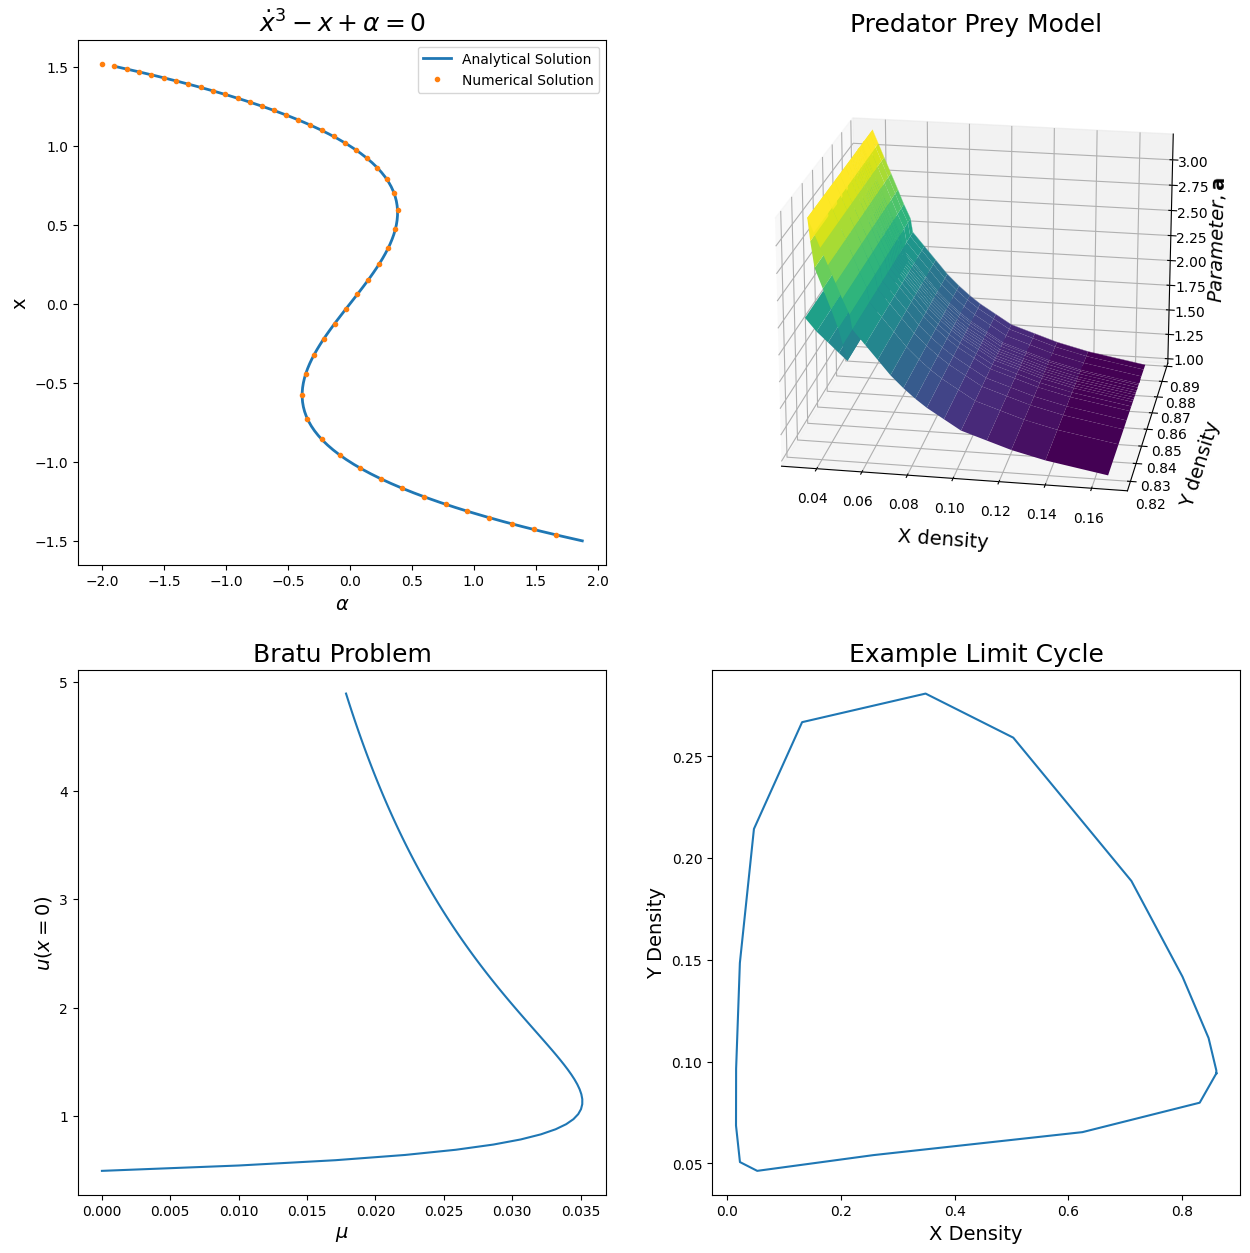

In [65]:
from continuation import continuation
from functions import bratu, h, PPM
from PDEs import Grid, BoundaryCondition, construct_A_and_b
from scipy.integrate import solve_ivp

plt.style.use('default')

y = np.linspace(-1.5,1.5,100)

result = continuation(h,x0 = [1],par0 = [-2],
                   vary_par = 0,
                   step_size = 0.1,
                   max_steps = 50,
                   solve_for = 'equilibria')
u = result.u
alpha = result.alpha

fig = plt.figure(figsize=(15, 15))

# Create the first plot
ax0 = fig.add_subplot(2, 2, 1)
ax0.plot(y - y**3, y, label='Analytical Solution', linewidth=2)
ax0.plot(alpha, u[0], 'o', markersize=3, label='Numerical Solution')
ax0.set_title(r"$\dot{x}^3 - x + \alpha = 0$", fontsize=18)
ax0.set(xlabel=r'$\alpha$', ylabel='x')
ax0.xaxis.label.set_size(14)
ax0.yaxis.label.set_size(14)
ax0.legend(loc="best")

# Numerical continuation on the PPM problem for limit cycles

result = continuation(PPM,x0 = [0.5,0.5,20],par0 = [1,0.1,0.1],
                   vary_par = 0,
                   step_size = 0.1,
                   max_steps = 30,
                   solve_for = 'limit_cycle')
u = result.u
alpha = result.alpha

# Create the 3D axis for the middle plot

ax1 = fig.add_subplot(2, 2, 2, projection='3d')

# Create a 3D surface plot of u[0] against u[1] against u[2]

X, Y = np.meshgrid(u[1], u[0])
Z = np.array([alpha for _ in range(len(u[0]))])

ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_title("Predator Prey Model", fontsize=18)
ax1.set_xlabel('X density', labelpad=10,fontsize = 14)  # Add padding to the axis label
ax1.set_ylabel('Y density', labelpad=10,fontsize = 14)  # Add padding to the axis label
ax1.set_zlabel(r"$Parameter,  \mathbf{a}$", labelpad=5, fontsize = 14)  # Add padding to the axis label
ax1.view_init(elev=20, azim=-80)  # Adjust the viewing angle

# Example limit cycle found through continuation

results = continuation(PPM, [0.5,0.5,20],[1,0.1,0.1],vary_par=0,step_size=0.1,max_steps=20,solve_for='limit_cycle')
#%%

x0 = results.u[:-1]
T = results.u[-1]
alpha = results.alpha
idx = 5
result = solve_ivp(lambda t,x: PPM(x,t,[alpha[idx],0.1,0.1]),[0,T[idx]],x0[:,idx])


ax3 = fig.add_subplot(2, 2, 4)
ax3.plot(result.y[0], result.y[1])
ax3.set_title("Example Limit Cycle", fontsize=18)
ax3.set(xlabel='X Density', ylabel='Y Density')
ax3.xaxis.label.set_size(14)
ax3.yaxis.label.set_size(14)

# Numerical continuation on Bratu problem

grid = Grid(N=100, a=0, b=10)
bc_left = BoundaryCondition('dirichlet', [lambda t: 5],grid);bc_right = BoundaryCondition('dirichlet',[lambda t: 10],grid)
A,b = construct_A_and_b(grid,bc_left,bc_right)
dx = grid.dx
u0 = np.zeros(len(grid.x[1:-1]))

result = continuation(bratu,
    x0 = u0,  
    par0=[0,1,dx,A],  
    vary_par=0,  
    step_size=0.01,  
    max_steps=100,  
    solve_for = 'equilibria')

u=result.u
alpha = result.alpha

ax2 = fig.add_subplot(2, 2, 3)
ax2.plot(alpha, u[0])
ax2.set_title("Bratu Problem", fontsize=18)
ax2.set(xlabel=r"$\mu$", ylabel=r"$u(x=0)$")
ax2.xaxis.label.set_size(14)
ax2.yaxis.label.set_size(14)

In [64]:
# Numerical continuation on the PPM problem for limit cycles

result = continuation(PPM,x0 = [0.5,0.5,20],par0 = [1,0.1,0.1],
                   vary_par = 0,
                   step_size = 0.1,
                   max_steps = 30,
                   solve_for = 'limit_cycle')
u = result.u
alpha = result.alpha

x0 = u[:-2,:]
T = u[-2]

idx = 19
results = solve_ivp(lambda t,x: PPM(x,t,[alpha[idx],0.1,0.1]), [0,T[idx]],x0[idx])

plt.plot(result[0],result[1])

IndexError: index 19 is out of bounds for axis 0 with size 1

## Key Software Decisions (40% of report mark)

The key design decisions should be described; explain your thinking behind the overall structure and interfaces of your code. 
If your code structure is intricate, a block diagram might be appropriate. 

Did you use SciPy's root function, NumPy with dense arrays, or SciPy with sparse arrays?  

Think about how you divided your code into functions and made sure that the different parts of your code could work together to solve general problems.

#### General Design Decisions

1) customization is all argument based
2) lots of string inputs
3) how parameters are passed
4) major functions output objects (object oriented approach)
5) Why were the solvers implemented as they are? 
6) how ODE functions need to be presented to each solver
7) error handling and invalid inputs - improves the user experience and ensures proper input data.

Throughout all the functions developed, the user is able to customize the function to their needs. This is done by passing arguments to the functions. For example, in the diffusion_solver function, the user can choose the finite difference method, the boundary conditions, the initial conditions, the source term, the diffusion coefficient, the time range, the number of time steps, the grid spacing, the grid points, and the domain limits. This allows the user to solve a wide range of problems using the same function. 

However whilst this does neatly package all functionality in one place, user might be overwhelmed by all the arguments and it may be easy for code to become less readable.

All functions are accompanied by a docstring which allows for the user to easily understand what each function does and what arguments are required.

#### Alternative design decisions

What alternative designs might have been appropriate and why were they not pursued?





#### Integration

1) choose from RK4 and euler using string (user can't choose their own stepping function)
2) range of times
3) 

In this block of code, the following design decisions have been made:

3. The `solve_to` function is designed as a wrapper that selects and applies the chosen integration method based on the `method` argument. This design decision provides a unified interface for the user, allowing them to switch between different integration methods by simply changing the `method` argument.
4. The `solve_to` function accepts a list of parameters and an optional maximum time step `deltat_max`. This enables users to customize the integration process by specifying different parameters or adjusting the time step for increased accuracy.
5. The code uses a combination of Python lists and NumPy arrays for storing and manipulating data. This decision leverages the efficient numerical operations provided by NumPy while still offering the convenience and flexibility of Python lists.
6. Error handling has been implemented using `raise ValueError` to provide informative error messages for invalid input values or unrecognized method arguments.
7. A custom `result` class is defined and returned by the `solve_to` function, which includes the solution array `x` and the time steps array `t_space` as attributes. This design choice provides a structured and convenient way to access the results of the integration process.

#### Shooting

In this block of code, the following design decisions have been made:

1. The code is designed to find the initial conditions and period of a limit cycle for a given ordinary differential equation (ODE) system.
2. Two functions are defined: `lim_cycle_conditions` and `shooting`. The `lim_cycle_conditions` function computes the difference between the initial and final states of the system over one period. The `shooting` function uses a solver to find the initial conditions and period of the limit cycle.
3. The `lim_cycle_conditions` function takes a function `func`, initial conditions `init`, and a list of parameters `parameters`. This design choice allows users to provide custom ODEs and initial conditions for the system.
4. The `shooting` function accepts a solver function as an argument, which provides flexibility in choosing the root-finding method. Currently, the code supports the `scipy.optimize.root` solver.
5. Error handling is not explicitly implemented in this code block. It relies on the underlying solver to handle errors or convergence issues.
6. The `shooting` function returns a custom `result` class with attributes `x` and `T`, representing the initial conditions and period of the limit cycle, respectively. This design choice provides a structured and convenient way to access the results of the limit cycle search.

Overall, this code is designed to provide a flexible and modular approach to finding limit cycles for user-defined ODE systems, leveraging the power of existing solvers and providing a convenient interface for accessing the results.

#### Continuation

The code for continuation is higly modular, with nearly all functionality being taken out of the continuation function and spread across the other functions in continuation.py. This allows for easy troublshooting of problems and an easy-to-follow structure. The user can 

lim cycle tracker calls shooting

1) parameter being varied inputted as index in par0

4. Flexibility: The `continuation` function, which serves as the main function for performing continuation, allows the user to specify various parameters such as the ODE function to solve (`myode`), initial guesses (`x0`), parameter array (`par0`), index of the parameter being varied (`vary_par`), step size (`step_size`), maximum steps (`max_steps`), type of solution to find (`solve_for`), and the continuation method (`method`).

5. Encapsulation: The code uses a custom `result` class to store and return the results of the continuation. This allows for a cleaner return format and provides a convenient way to access the solution and parameter values.

6. Solver support: The code currently only supports the `scipy.optimize.root` solver for finding solutions. However, the design allows for the possibility of adding support for more solvers in the future by passing the `solver` argument to the `continuation` function.



#### Finite Difference Solvers

The finite difference solvers included in this package are `BVP_solver` and `diffusion_solver`. To solve boundary value PDE problems, a matrix formulation is used in all cases. For instance, below is the finite difference analogue for explicit euler: $$ \mathbf{u_{n+1}} = \frac{\delta tD}{\delta x^2}(\mathbf{Au_{n}} + \mathbf{b}) + \delta tq(\mathbf{x},t,\mathbf{u}) + \mathbf{u_{n}}. $$ Where A is a tri-diagonal matrix and b is a vector. In both finite difference solvers developed, boundary conditions are passed to the function as an object generated by the `BoundaryCondition` function where the user specifies the type of boundary condition with a str input and the associated values. Alternatively these conditions could be passed as arguments directly into the solvers, whilst this would be more convenient for the user, requiring the user to create a boundary condition object separately allows for more flexibility in the future. For example, if the user wanted to solve a problem with a boundary condition that is not currently supported, they could create a new boundary condition class and pass this to the solver, in addition to this the structure of the code becomes much cleaner.

The attributes of the object returned by BoundaryCondition contain information for how `construct_A_and_b` builds the A and b matrices as part of the finite difference analogue: namely the adjusted A entries and information on the dimension of the problem (if dirichlet condition set then dimension reduced by one). Before adjusting for boundary conditions, the A matrix is constructed initially using a separate function `gen_diag_mat` where input can be adjusted to generate different values along the diagonals, allowing the possibility in the future to use other higher order methods such as third and fourth order FTCS schemes. The matrix b is returned as a function and treated as such in all code even if user inputs constants. This allows for cleaner code that simply converts user input into a function if its not already one and applies to all scenarios.

This same principle is applied to the source term and initial conditions, i.e. the user can pass a function or a constant and the code will convert it to a function in the latter case. This allows for cleaner code and more flexible inputs. The decision was made to allow handling for both sparse and dense matrices. Both dense and sparse matrices have advantages over eachother in certain scenarios and the user can accomodate for these occasions. Furthermore the user can choose from a mixture of explicit, implicit and semi-implicit methods for solving the diffusion equation, this allows the user total freedom in choosing the most appropriate method for their problem.

Various design decisions were made to ensure stability of the problem regardless of the user input. For instance, the time-step size $\delta t$, is automatically recalculated as $\frac{\delta x^2}{D}$ if `explicit-euler` method is chosen and the user inputted value of $\delta t$ leads to oscillations. In addition to this the method of lines makes use of `scipy.integrate.solve_ivp` which takes care of the time-step restriction.

## Reflective learning log (30% of report mark)

This is less about explaining what you did each week and more about taking stock of what you learned over the term, the implications of what you learned, and what you would do differently.  The unit website has specific questions that we would like to see addressed.  This section should be text only and not have any code.  The format is up to you (e.g. paragraphs or bullet points); the content is more important.

What did I learn about the mathematical algorithms? I.e., solving boundary value problems, numerical ill-conditioning, etc.

What did I learn about software engineering? How have I progressed in my abilities?

- Different types of data (numpy array vs list etc.)

What are the short-term implications of what I've learnt?

- Useful in future units
- useful in understanding the reaction-diffusion equation and how boundary conditions affect the solution

What are the long-term implications of what I've learnt?

- Useful in future software development projects
        -> how to structure code
        -> how to write documentation
        -> how to write tests
        -> how to use version control
        -> how to write a package
        -> how to profile code
        -> how to write a reflective learning log

What would I have done differently if I started the unit over again?

- setup functions as f(t,x,args) instead of f(x,t,args) to be consistent with scipy
- setting up everything as a class:
        limit cycle, equilibria = attributes of a continuation class
        imex, explicit_euler, implicit_euler, lines, crank_nicolson = attributes of diffusion_solver class
-solve_to input stepper directly as function (allows user to build and choose their own stepper)

What will I do differently in the future?
- comment code much more as I write it
- write tests as I write code
- write documentation as I write code
- use version control from the start
- use a linter from the start
- use profiling more actively to optimize code